In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report,auc
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report,make_scorer,precision_recall_curve
import numpy as np

In [3]:
data = pd.read_csv('/Users/jagan/Documents/coding/projects/fraud-detection-system/data/processed/merged_ieee_cis.csv')

In [4]:
cat_cols = data.select_dtypes(include='object').columns
cat_cols

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [5]:
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

In [6]:
print(data.dtypes[cat_cols])

ProductCD        int64
card4            int64
card6            int64
P_emaildomain    int64
R_emaildomain    int64
M1               int64
M2               int64
M3               int64
M4               int64
M5               int64
M6               int64
M7               int64
M8               int64
M9               int64
id_12            int64
id_15            int64
id_16            int64
id_23            int64
id_27            int64
id_28            int64
id_29            int64
id_30            int64
id_31            int64
id_33            int64
id_34            int64
id_35            int64
id_36            int64
id_37            int64
id_38            int64
DeviceType       int64
DeviceInfo       int64
dtype: object


In [7]:
data.dtypes.value_counts().head(434)

float64    399
int64       35
Name: count, dtype: int64

In [8]:
data.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [9]:

cat_cols = data.select_dtypes(include='object').columns.tolist()
print(f"Categorical columns to encode: {cat_cols}")


for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

print(data[cat_cols].dtypes)

Categorical columns to encode: []
Series([], dtype: object)


In [10]:
feature_cols = [col for col in data.columns if col not in ['isFraud']]
X = data[feature_cols]
y = data['isFraud']

In [11]:
X["TransactionAmt_log"] = np.log1p(X["TransactionAmt"])

In [12]:
X["DT_M"] = X["TransactionDT"] / (60 * 60 * 24 * 30)
X["DT_W"] = X["TransactionDT"] / (60 * 60 * 24 * 7)
X["DT_D"] = X["TransactionDT"] / (60 * 60 * 24)
X["DT_hour"] = (X["TransactionDT"] / 3600) % 24

In [13]:
for col in ["card1", "card2", "addr1", "DeviceInfo", "id_30", "id_31"]:
    if col in X.columns:
        freq = X[col].value_counts(dropna=False)
        X[col + "_freq"] = X[col].map(freq)

In [14]:
X["TransactionAmt_bin"] = pd.qcut(X["TransactionAmt"], 10, duplicates="drop").cat.codes

In [15]:
X["card1_amt_mean"] = X.groupby("card1")["TransactionAmt"].transform("mean")
X["card1_amt_std"] = X.groupby("card1")["TransactionAmt"].transform("std")
X["card1_trans_count"] = X.groupby("card1")["TransactionID"].transform("count")

In [16]:
X = X.select_dtypes(include=[np.number]).fillna(-999)

In [17]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = 1
auc_scores = []
reports = []


print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 3.0.4


In [18]:
for train_idx, val_idx in skf.split(X, y):
    print(f"\n Fold {fold}")

    #Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    #Model
    model = xgb.XGBClassifier(
        n_estimators=1200,
        max_depth=7,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        eval_metric="aucpr",
        early_stopping_rounds=100,
        random_state=42,
        tree_method="hist"
    )

    #Train
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=200)

    #Probabilities
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    #Best F1 threshold
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    print(f"Best Threshold = {best_threshold:.3f}, F1 = {f1_scores[best_idx]:.3f}")

    #Predictions with custom threshold
    y_pred_custom = (y_pred_proba >= best_threshold).astype(int)

    #Metrics
    auc = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append(auc)

    report = classification_report(y_val, y_pred_custom, output_dict=True, zero_division=0)
    reports.append(report)

    print(f"Fold {fold} AUC: {auc:.4f}")
    print(classification_report(y_val, y_pred_custom, zero_division=0))

    fold += 1



 Fold 1
[0]	validation_0-aucpr:0.35022
[200]	validation_0-aucpr:0.62574
[400]	validation_0-aucpr:0.69178
[600]	validation_0-aucpr:0.73066
[800]	validation_0-aucpr:0.75762
[1000]	validation_0-aucpr:0.77701
[1199]	validation_0-aucpr:0.79111
Best Threshold = 0.790, F1 = 0.743
Fold 1 AUC: 0.9645
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    113976
           1       0.82      0.68      0.74      4132

    accuracy                           0.98    118108
   macro avg       0.90      0.84      0.87    118108
weighted avg       0.98      0.98      0.98    118108


 Fold 2
[0]	validation_0-aucpr:0.39374
[200]	validation_0-aucpr:0.63309
[400]	validation_0-aucpr:0.69609
[600]	validation_0-aucpr:0.73725
[800]	validation_0-aucpr:0.76620
[1000]	validation_0-aucpr:0.78666
[1199]	validation_0-aucpr:0.80275
Best Threshold = 0.784, F1 = 0.750
Fold 2 AUC: 0.9668
              precision    recall  f1-score   support

           0       0.99      0

<Figure size 1000x600 with 0 Axes>

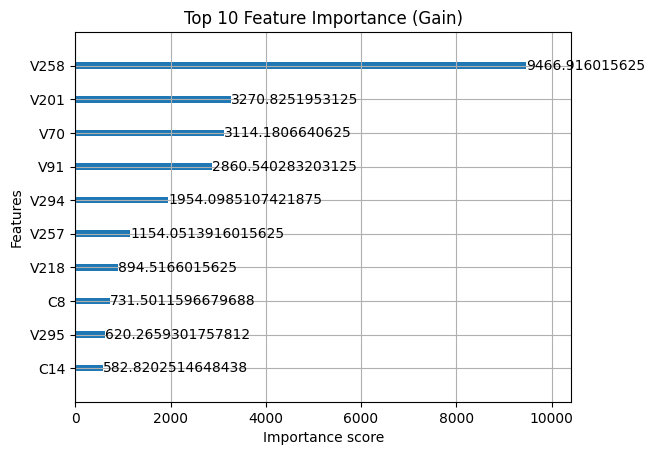

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plot_importance(model, importance_type='gain', max_num_features=10)
plt.title('Top 10 Feature Importance (Gain)')
plt.show()

In [20]:
import joblib

joblib.dump(model, '/Users/jagan/Documents/coding/projects/fraud-detection-system/models/xgb_model.pkl')

feature_cols = X.columns.tolist()

joblib.dump(feature_cols,'/Users/jagan/Documents/coding/projects/fraud-detection-system/models/feature_cols.pkl')



['/Users/jagan/Documents/coding/projects/fraud-detection-system/models/feature_cols.pkl']